# Deep MicroBiome

Aug. 14. 2019
@ Youngwon (youngwon08@gmail.com)

In [1]:
import os
import json
import numpy as np
import pandas as pd
import copy
import logging
import sys

import keras.backend as k
import tensorflow as tf

import matplotlib.pyplot as plt
%matplotlib inline

os.environ['CUDA_VISIBLE_DEVICES']=''

/DATA/home/muha/.local/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtyp

In [2]:
from deepbiome.deepbiome import *

In [3]:
if not tf.__version__.startswith('2'): 
    config = tf.ConfigProto(gpu_options=tf.GPUOptions(allow_growth=True))
    k.set_session(tf.Session(config=config))

## Pick Models

In [4]:
save = False
# kfold=1000
kfold=20
network_model_keys = ['optimizer','lr','decay']
architecture_keys = ['weight_decay', 'weight_l1_penalty', #'weight_l2_penalty',
                     'tree_thrd', 'weight_initial',
                     'batch_normalization','drop_out']
network_training_keys = ['batch_size','epochs']

logging.basicConfig(format = '[%(name)-8s|%(levelname)s|%(filename)s:%(lineno)s] %(message)s',
                    level=logging.DEBUG)
log = logging.getLogger()

In [5]:
#######################################################################
# filenames = 'simulation_s0.Rmd'
# models = [
#           'simulation_s0/simulation_s0_deep',
#           'simulation_s0/simulation_s0_deep_l1',
#           'simulation_s0/simulation_s0_deepbiome',
#          ]

# models_aka = [
#           'DNN',
#           'DNN+l1',
#           'DeepBiome',
#          ]
# num_classes = 0
########################################################################
# filenames = 'simulation_s1.Rmd'
# models = [
#           'simulation_s1/simulation_s1_deep',
#           'simulation_s1/simulation_s1_deep_l1',
#           'simulation_s1/simulation_s1_deepbiome',
#          ]

# models_aka = [
#           'DNN',
#           'DNN+l1',
#           'DeepBiome',
#          ]
# num_classes = 0
# ########################################################################
# filenames = 'simulation_s2.Rmd'
# models = [
#           'simulation_s2/simulation_s2_deep',
#           'simulation_s2/simulation_s2_deep_l1',
#           'simulation_s2/simulation_s2_deepbiome',
#          ]

# models_aka = [
#           'DNN',
#           'DNN+l1',
#           'DeepBiome',
#          ]
# num_classes = 1
# #######################################################################
filenames = 'simulation_s3.Rmd'
models = [
          'simulation_s3/simulation_s3_deep',
          'simulation_s3/simulation_s3_deep_l1',
          'simulation_s3/simulation_s3_deepbiome',
         ]

models_aka = [
          'DNN',
          'DNN+l1',
          'DeepBiome',
         ]
num_classes = 3
# # ########################################################################
# filenames = 'simulation_s4.Rmd'
# models = [
#           'simulation_s4/simulation_s4_deep',
#           'simulation_s4/simulation_s4_deep_l1',
#           'simulation_s4/simulation_s4_deepbiome',
#          ]

# models_aka = [
#           'DNN',
#           'DNN+l1',
#           'DeepBiome',
#          ]
# num_classes = 0
########################################################################
# filenames = 'simulation_s5.Rmd'
# models = [
#           'simulation_s5/simulation_s5_deep',
#           'simulation_s5/simulation_s5_deep_l1',
#           'simulation_s5/simulation_s5_deepbiome',
#          ]

# models_aka = [
#           'DNN',
#           'DNN+l1',
#           'DeepBiome',
#          ]
# num_classes = 0
########################################################################

In [6]:
model_network_info = {}
model_path_info = {}
for model_path in models:
    config_data = configuration.Configurator('%s/config/path_info.cfg' % model_path, log, verbose=False)
    config_data.set_config_map(config_data.get_section_map())
    config_network = configuration.Configurator('%s/config/network_info.cfg' % model_path, log, verbose=False)
    config_network.set_config_map(config_network.get_section_map())

    model_path_info[model_path] = config_data.get_config_map()
    model_network_info[model_path] = config_network.get_config_map()
    
if num_classes == 0: y_names = ['loss','correlation_coefficient']
elif num_classes==1: y_names = ['loss','binary_accuracy','sensitivity','specificity','gmeasure', 'auc']
else: y_names=['loss','categorical_accuracy','precision','recall','f1', 'auc']

if num_classes == 0: measure_index = np.array([0,1])
elif num_classes==1: measure_index = np.array([2,3,4,1,5])
else: measure_index = np.array([1,2,3,4,5])

## Accuracy

In [7]:
results = []
# log.info('%20s & %s' % ('model', '& '.join(['%s ' % name for name in np.array(y_names)[[measure_index]]])))
print('%10s & %s \\\\\ \hline' % ('model', '& '.join(['%7s &   (sd) ' % name for name in np.array(y_names)[[measure_index]]])))
# for model, aka in zip(models, models_aka):
#     evaluation = np.load('%s/eval.npy' % model)
#     log.info('%20s: %s' % (aka, ''.join(['%10.4f (%10.4f)'%(mean, std) for mean, std in zip(np.mean(evaluation, axis=0),np.std(evaluation, axis=0))])))
#     results.append(np.vstack([np.mean(evaluation, axis=0),np.std(evaluation, axis=0)]).transpose())
for model, aka in zip(models, models_aka):
    train_evaluation = np.load('%s/train_eval.npy' % model)[:,measure_index]
    train_res = '&'.join(['%7.3f & %7.3f'%(mean, std) for mean, std in zip(np.mean(train_evaluation, axis=0),np.std(train_evaluation, axis=0))])
    test_evaluation = np.load('%s/test_eval.npy' % model)[:,measure_index]
    test_res = '&'.join(['%7.3f & %7.3f'%(mean, std) for mean, std in zip(np.mean(test_evaluation, axis=0),np.std(test_evaluation, axis=0))])
#     log.info('%s & %s & %s \\\\' % (aka, train_res, test_res))
    print('%10s & %s & %s \\\\' % (aka, test_res, train_res))
#     results.append(np.vstack([np.mean(evaluation, axis=0),np.std(evaluation, axis=0)]).transpose())

     model & categorical_accuracy &   (sd) & precision &   (sd) &  recall &   (sd) &      f1 &   (sd) &     auc &   (sd)  \\\ \hline
       DNN &   0.752 &   0.045&  0.620 &   0.136&  0.599 &   0.105&  0.599 &   0.115&  0.856 &   0.041 &   0.854 &   0.063&  0.741 &   0.188&  0.718 &   0.149&  0.718 &   0.166&  0.941 &   0.044 \\
    DNN+l1 &   0.760 &   0.042&  0.668 &   0.139&  0.612 &   0.090&  0.618 &   0.104&  0.863 &   0.043 &   0.864 &   0.058&  0.794 &   0.160&  0.731 &   0.130&  0.739 &   0.146&  0.948 &   0.037 \\
 DeepBiome &   0.815 &   0.066&  0.720 &   0.151&  0.714 &   0.115&  0.711 &   0.135&  0.900 &   0.080 &   0.880 &   0.072&  0.804 &   0.170&  0.793 &   0.135&  0.791 &   0.157&  0.942 &   0.084 \\


# Choose Model

In [8]:
num=2
model_path = models[num]
model_aka = models_aka[num]

config_data = configuration.Configurator('%s/config/path_info.cfg' % model_path, log, verbose=False)
config_data.set_config_map(config_data.get_section_map())
config_network = configuration.Configurator('%s/config/network_info.cfg' % model_path, log, verbose=False)
config_network.set_config_map(config_network.get_section_map())

path_info = config_data.get_config_map()
network_info = config_network.get_config_map()

path_info['data_info']['data_path'] = '/'.join(path_info['data_info']['data_path'].split('/')[2:])
path_info['data_info']['tree_info_path'] = '/'.join(path_info['data_info']['tree_info_path'].split('/')[2:])
try: path_info['data_info']['count_list_path'] = '/'.join(path_info['data_info']['count_list_path'].split('/')[2:])
except: pass
try: path_info['data_info']['count_path'] = '/'.join(path_info['data_info']['count_path'].split('/')[2:])
except: pass
path_info['data_info']['idx_path'] = '/'.join(path_info['data_info']['idx_path'].split('/')[2:])

path_info['model_info']['model_dir'] = './%s/%s'%(model_path,path_info['model_info']['model_dir'])

log.info('%22s : %s' % ('model', model_path))
log.info('%22s : %s' % ('model_aka', model_aka))
for k in architecture_keys:
    log.info('%22s : %s' % (k, network_info['architecture_info'].get(k, None)))
for k in network_model_keys:
    log.info('%22s : %s' % (k, network_info['model_info'].get(k, None)))
for k in network_training_keys:
    log.info('%22s : %s' % (k, network_info['training_info'].get(k, None)))

[root    |INFO|<ipython-input-8-6e33d2ded9d6>:23]                  model : simulation_s3/simulation_s3_deepbiome
[root    |INFO|<ipython-input-8-6e33d2ded9d6>:24]              model_aka : DeepBiome
[root    |INFO|<ipython-input-8-6e33d2ded9d6>:26]           weight_decay : phylogenetic_tree
[root    |INFO|<ipython-input-8-6e33d2ded9d6>:26]      weight_l1_penalty : None
[root    |INFO|<ipython-input-8-6e33d2ded9d6>:26]              tree_thrd : None
[root    |INFO|<ipython-input-8-6e33d2ded9d6>:26]         weight_initial : glorot_uniform
[root    |INFO|<ipython-input-8-6e33d2ded9d6>:26]    batch_normalization : False
[root    |INFO|<ipython-input-8-6e33d2ded9d6>:26]               drop_out : 0
[root    |INFO|<ipython-input-8-6e33d2ded9d6>:28]              optimizer : adam
[root    |INFO|<ipython-input-8-6e33d2ded9d6>:28]                     lr : 0.01
[root    |INFO|<ipython-input-8-6e33d2ded9d6>:28]                  decay : 0.0001
[root    |INFO|<ipython-input-8-6e33d2ded9d6>:30]          

In [9]:
evaluation = np.load('%s/test_eval.npy' % model_path)
log.info('\t %s'%' '.join(['%s' % name for name in y_names]))

_ = [log.info('%d fold : %s' % (i,line)) for i, line in enumerate(evaluation)]
log.info('Mean   : %s' % np.mean(evaluation, axis=0))
log.info('Std   : %s' % np.std(evaluation, axis=0))

# _ = [print('%d fold & %s \\tabularnewline' % (i, ' & '.join(['%.3f'% v for v in line]))) for i, line in enumerate(evaluation)]
# print('Mean & %s \\tabularnewline' % (' & '.join(['%.3f'% v for v in np.mean(evaluation, axis=0)])))
# print('Sd & %s \\tabularnewline' % (' & '.join(['%.3f'% v for v in np.std(evaluation, axis=0)])))

[root    |INFO|<ipython-input-9-65b4b58a34e1>:2] 	 loss categorical_accuracy precision recall f1 auc
[root    |INFO|<ipython-input-9-65b4b58a34e1>:4] 0 fold : [0.30231294 0.87599999 0.83385623 0.77652025 0.79438835 0.95322645]
[root    |INFO|<ipython-input-9-65b4b58a34e1>:4] 1 fold : [0.80170077 0.74800003 0.69001281 0.67926461 0.68192732 0.88567853]
[root    |INFO|<ipython-input-9-65b4b58a34e1>:4] 2 fold : [0.59944046 0.80800003 0.67325574 0.66343862 0.6651324  0.88168979]
[root    |INFO|<ipython-input-9-65b4b58a34e1>:4] 3 fold : [0.58931917 0.80800003 0.74308181 0.69661498 0.70152527 0.87173593]
[root    |INFO|<ipython-input-9-65b4b58a34e1>:4] 4 fold : [0.62047589 0.80400002 0.72795165 0.71513486 0.7210145  0.90500277]
[root    |INFO|<ipython-input-9-65b4b58a34e1>:4] 5 fold : [0.55908775 0.852      0.81899434 0.79851371 0.80756181 0.93226779]
[root    |INFO|<ipython-input-9-65b4b58a34e1>:4] 6 fold : [0.65913111 0.764      0.62168586 0.61895818 0.60132158 0.86512738]
[root    |INFO|<i

[root    |INFO|<ipython-input-9-65b4b58a34e1>:4] 64 fold : [0.53022486 0.824      0.76349771 0.72214723 0.73217052 0.91814971]
[root    |INFO|<ipython-input-9-65b4b58a34e1>:4] 65 fold : [0.57901824 0.78799999 0.53422576 0.59937489 0.56203097 0.83392513]
[root    |INFO|<ipython-input-9-65b4b58a34e1>:4] 66 fold : [0.64430797 0.73199999 0.62509304 0.57404399 0.58804154 0.851749  ]
[root    |INFO|<ipython-input-9-65b4b58a34e1>:4] 67 fold : [0.6111688  0.81199998 0.76486677 0.7065677  0.72525519 0.89612603]
[root    |INFO|<ipython-input-9-65b4b58a34e1>:4] 68 fold : [0.6577183  0.736      0.49193433 0.55836517 0.52050674 0.84107345]
[root    |INFO|<ipython-input-9-65b4b58a34e1>:4] 69 fold : [0.51581395 0.86799997 0.82258701 0.80397797 0.81170183 0.94792968]
[root    |INFO|<ipython-input-9-65b4b58a34e1>:4] 70 fold : [0.48982459 0.80000001 0.53827161 0.63110286 0.57428598 0.89184976]
[root    |INFO|<ipython-input-9-65b4b58a34e1>:4] 71 fold : [0.46692318 0.83600003 0.80903226 0.70846474 0.74811

## Weight estimation of DeepBiom

We identify the largest weight estimatio of neurons in two hidden layers; by doing this, we can identify the strongest phylogenetic connections. We compute the True Positive Rate (``TPR``, sensitivity), True Negative Rate (``TNR``, specificity), and their geometric mean (i.e., ``g-Measure``). The false discovery rate (FDR) would be ``FDR = 1-TPR`` in our case.

In [10]:
weight_path = '%s/weight/weight_0.h5' % (model_path)
trained_weight_list = deepbiome_get_trained_weight(log, network_info, path_info, num_classes, weight_path)

Instructions for updating:
Colocations handled automatically by placer.


[tensorflow|WARNING|deprecation.py:328] From /usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/resource_variable_ops.py:432: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.


In [11]:
trained_weight_list

[array([[ 6.8835601e-02,  7.5788138e-04,  9.7450363e-03, ...,
          2.1947986e-03, -1.8630422e-03,  1.4886589e-03],
        [-2.4362572e-03,  5.2348266e+00,  3.2907497e-02, ...,
          1.4961542e-03,  2.1112470e-03,  3.7218664e-02],
        [ 1.9826530e-03,  4.7056237e-03,  8.8504702e-01, ...,
          3.5030214e-04,  7.4458483e-04,  3.8231563e-04],
        ...,
        [-6.3345401e-04,  9.8157180e-03,  1.9846655e-02, ...,
          2.0543933e-02,  5.8772182e-04, -1.2038143e-02],
        [-2.3092693e-03,  1.4776358e-02,  1.2009016e-02, ...,
          8.6699781e-04,  1.4701061e-01,  1.1450489e-02],
        [ 9.2872471e-04,  7.8618536e-03, -2.5522837e-03, ...,
         -1.7181372e-03,  1.8618914e-03,  1.1261588e+00]], dtype=float32),
 array([[ 9.23373029e-02,  8.43170739e-04, -2.97671719e-03,
         -1.40762457e-03, -2.50464492e-03, -1.95545191e-03,
         -5.54621452e-04, -5.57824736e-04,  4.19246615e-04,
          9.05894150e-04, -2.19538691e-03,  1.33233366e-03,
          

### Performance

In [12]:
tw_1 = np.load('%s/tw_1.npy' % path_info['data_info']['data_path'])
tw_2 = np.load('%s/tw_2.npy' % path_info['data_info']['data_path'])
tw_3 = np.load('%s/tw_3.npy' % path_info['data_info']['data_path'])
tw_4 = np.load('%s/tw_4.npy' % path_info['data_info']['data_path'])
true_tree_weight_list = []
for fold in range(kfold):
    true_tree_weight_list.append(np.array([tw_1[fold],tw_2[fold],tw_3[fold],tw_4[fold]]))
# true_tree_weight_list = np.array(true_tree_weight_list)
# np.save('../deepbiome/tests/data/true_weight_list.npy', true_tree_weight_list)

In [13]:
trained_weight_path_list = ['%s/weight/weight_%d.h5' % (path_info['model_info']['model_dir'], i) for i in range(kfold)]

In [14]:
summary = deepbiome_taxa_selection_performance(log, network_info, path_info, num_classes, true_tree_weight_list, trained_weight_path_list)
summary.iloc[0,0] = model_aka

In [15]:
summary

,Model,PhyloTree,No. true taxa,No. total taxa,Sensitivity_mean,Sensitivity_std,Specificity_mean,Specificity_std,Gmeasure_mean,Gmeasure_std,Accuracy_mean,Accuracy_std
0,DeepBiome,Genus,19,48,0.978947,0.034912,0.691767,0.058883,0.822029,0.037831,0.694609,0.058294
1,,Family,15,40,0.966667,0.053748,0.850055,0.047506,0.905778,0.036920,0.851957,0.046766
2,,Order,4,23,0.975000,0.075000,0.840956,0.052331,0.904184,0.044634,0.842327,0.051725
3,,Class,3,17,0.966667,0.100000,0.800333,0.053061,0.877768,0.058410,0.803595,0.052143


In [16]:
print('%7s & %7s & %12s & %s' % ('Model', 'PhyloTree', 'True (Total)', ' & '.join(summary.columns[4:])))
print('---------------------------------------------------------------------------------------------------------------')
for i in range(summary.shape[0]):
    print('%10s & %7s & %7d (%d) & ' % tuple(summary.iloc[i,:4]) + ' &'.join(['%6.3f' % val for val in summary.iloc[i,4:]]) + ' \\\\')
    
# if save: 
#     # filenametexa = '.'.join(["%s_select_texa_1" % filename.split('.')[0], filename.split('.')[1]])
#     colname = ['Tree','True (Total)','Selected','Sensitivity','Specificity','gMeasure','Accuracy']
#     with open('%s/%s' % (analysis_dir, filename), mode='a') as f:
#     #     f.write('---\ntitle: "%s texa selection ver.1"\noutput: html_document\n---\n\n' % filename.split('.')[0])
#         f.write('\n## Texa Selection Preformance (ver 1): %s\n\n' % model_aka)
#         f.write('| %s |\n' % ('|'.join([v for v in colname])))
#         f.write('|'+'---|'*len(colname)+'\n')
#         for value in values:
#             f.write('| %s |\n' % ('|'.join(value)))

  Model & PhyloTree & True (Total) & Sensitivity_mean & Sensitivity_std & Specificity_mean & Specificity_std & Gmeasure_mean & Gmeasure_std & Accuracy_mean & Accuracy_std
---------------------------------------------------------------------------------------------------------------
 DeepBiome &   Genus &      19 (48) &  0.979 & 0.035 & 0.692 & 0.059 & 0.822 & 0.038 & 0.695 & 0.058 \\
           &  Family &      15 (40) &  0.967 & 0.054 & 0.850 & 0.048 & 0.906 & 0.037 & 0.852 & 0.047 \\
           &   Order &       4 (23) &  0.975 & 0.075 & 0.841 & 0.052 & 0.904 & 0.045 & 0.842 & 0.052 \\
           &   Class &       3 (17) &  0.967 & 0.100 & 0.800 & 0.053 & 0.878 & 0.058 & 0.804 & 0.052 \\


## Tree visualization

In [17]:
phylumn_color = ['lightsteelblue', 
                 'moccasin',
                 'darkseagreen',
                 'khaki',
                 'mediumturquoise',
                 'lightblue',
                 'thistle',
                 'tan',
                 'mistyrose',
                ]

### True

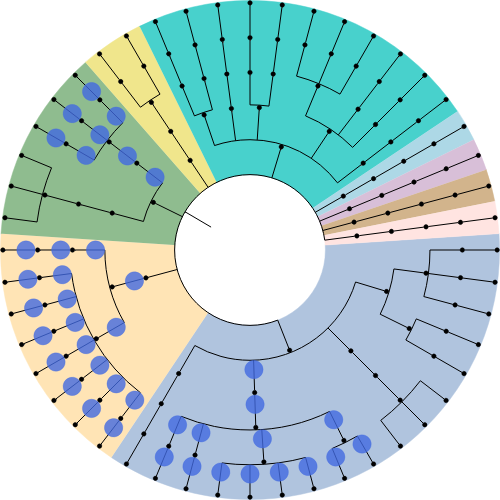

In [18]:
deepbiome_draw_phylogenetic_tree(log, network_info, path_info, num_classes,
                                 file_name='%%inline', img_w=500, branch_vertical_margin=20, arc_start=0, arc_span=360, 
                                 node_name_on=False, name_fsize=50, 
                                 tree_weight_on=True, tree_weight=true_tree_weight_list[0], weight_opacity=0.8, weight_max_radios=20, 
                                 background_color_on=True, phylumn_color=phylumn_color)

### Seleted taxa

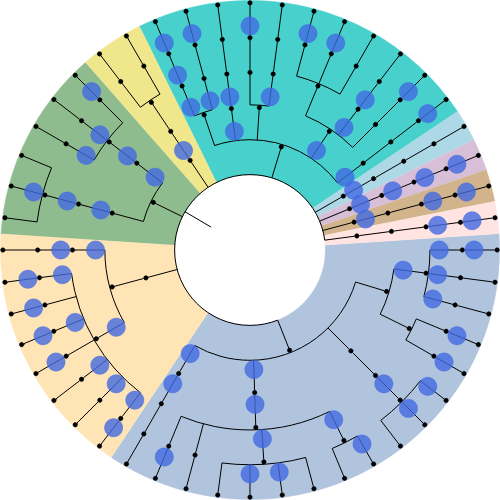

In [19]:
trained_weight = trained_weight_list[:4]
for i in range(4):
    trained_weight[i] = (trained_weight[i] > 1e-2).astype(np.float)

deepbiome_draw_phylogenetic_tree(log, network_info, path_info, num_classes,
                                 file_name='%%inline', img_w=500, branch_vertical_margin=20, arc_start=0, arc_span=360, 
                                 node_name_on=False, name_fsize=50, 
                                 tree_weight_on=True, tree_weight=trained_weight,
                                 weight_opacity=0.8, weight_max_radios=20, 
                                 background_color_on=True, phylumn_color=phylumn_color)

### Trained weight with size

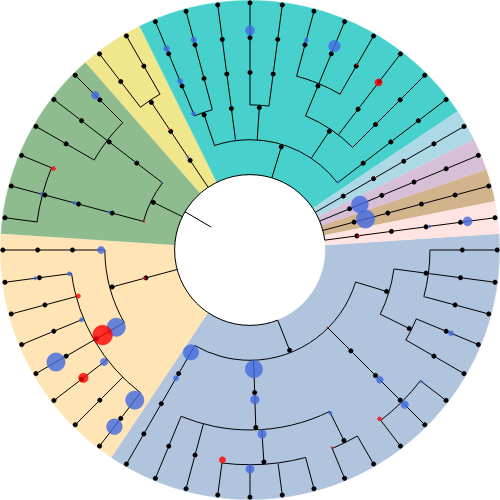

In [20]:
deepbiome_draw_phylogenetic_tree(log, network_info, path_info, num_classes,
                                 file_name='%%inline', img_w=500, branch_vertical_margin=20, arc_start=0, arc_span=360, 
                                 node_name_on=False, name_fsize=50, 
                                 tree_weight_on=True, tree_weight=trained_weight_list[:4],
                                 weight_opacity=0.8, weight_max_radios=20, 
                                 background_color_on=True, phylumn_color=phylumn_color)

### With name

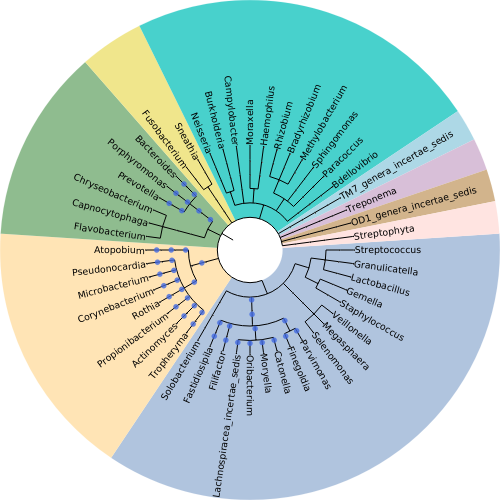

In [21]:
deepbiome_draw_phylogenetic_tree(log, network_info, path_info, num_classes,
                                 file_name='%%inline', img_w=500, branch_vertical_margin=20, arc_start=0, arc_span=360, 
                                 node_name_on=True, name_fsize=50, 
                                 tree_weight_on=True, tree_weight=true_tree_weight_list[0], weight_opacity=0.8, weight_max_radios=20, 
                                 background_color_on=True, phylumn_color=phylumn_color)

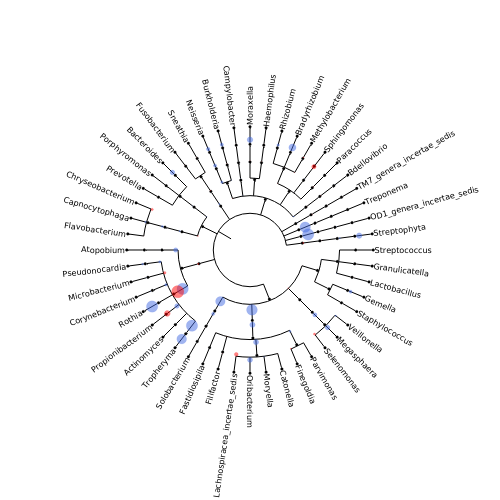

In [22]:
deepbiome_draw_phylogenetic_tree(log, network_info, path_info, num_classes,
                                 file_name='%%inline', img_w=500, branch_vertical_margin=20, arc_start=0, arc_span=360, 
                                 node_name_on=True, name_fsize=30, 
                                 tree_weight_on=True, tree_weight=trained_weight_list[:4],
                                 weight_opacity=0.5, weight_max_radios=30, 
                                 background_color_on=False, phylumn_color=phylumn_color)